# Automatic Differentiation

Inspired by https://www.youtube.com/watch?v=5F6roh4pmJU&ab_channel=MITOpenCourseWare


In [1]:
import numpy as np
import sympy as sp
from dataclasses import dataclass
import matplotlib.pyplot as plt

In [2]:
def babylonian_sqrt(x, n=50):
    t = 1
    for i in range(n):
        t = (t + x / t) / 2

    return t

In [3]:
def add_reflected_operations(cls):
    """
    A decorator that automatically adds reflected operations (__radd__, __rsub__, etc.)
    if the corresponding regular operations (__add__, __sub__, etc.) are defined.
    """

    def add_reflected_op(op):
        reflected_op_name = f"__r{op[2:]}"

        if hasattr(cls, op) and not hasattr(cls, reflected_op_name):

            def reflected_op(self, other):
                print("reflected_op")
                return getattr(other, op)(self)

            setattr(cls, reflected_op_name, reflected_op)

        return op

    ops_to_reflect = ["__add__", "__sub__", "__mul__", "__truediv__", "__floordiv__", "__mod__"]
    for op in ops_to_reflect:
        add_reflected_op(op)

    return cls

In [21]:
@dataclass
class D:
    v: float
    d: float

    def __init__(self, v, d = 0):
        if isinstance(v, D):
            self.v = v.v
            self.d = v.d
        else:
            self.v = v
            self.d = d

    def __add__(self, other):
        other = D(other)
        return D(self.v + other.v, self.d + other.d)

    def __sub__(self, other):
        other = D(other)
        return D(self.v - other.v, self.d - other.d)

    def __mul__(self, other):
        other = D(other)
        return D(self.v * other.v, self.d * other.v + self.v * other.d)

    def __pow__(self, other):
        other = D(other)
        log_self = log(self.v)
        pow_val = exp(other.v * log_self)
        # return D(pow_val, pow_val * (other.d * log_self + other.v / self.v * self.d))
        return D(pow_val, pow_val / self.v * (other.v * self.d + other.d * log_self * self.v))

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1
    
    def __mod__(self, other):
        other = D(other)
        return D(self.v % other.v, self.d)

    def __array__(self): return np.array(self.v)
    def __radd__(self, other): return self + other
    def __rsub__(self, other): return self - other
    def __rmul__(self, other): return self * other
    def __rtruediv__(self, other): return self / other
    def __rpow__(self, other): return self**other
    def __rmod__(self, other): return self % other

def log(x):
    # if sympy use sp.log instead
    if isinstance(x, sp.Expr):
        return sp.log(x)
    else:
        return np.log(x)

def exp(x):
    # if sympy use sp.log instead
    if isinstance(x, sp.Expr):
        return sp.exp(x)
    else:
        return np.exp(x)

In [14]:
a = D(2, 1)

babylonian_sqrt(a),  D(np.sqrt(2), 1 / (2 * np.sqrt(2)))

(D(v=1.414213562373095, d=0.35355339059327373),
 D(v=1.4142135623730951, d=0.35355339059327373))

In [66]:
x = sp.Symbol("x")
a = D(x, 1)
sqrt_a = babylonian_sqrt(a,3)
sp.simplify(sqrt_a.v)

(0.015625*x**4 + 0.4375*x**3 + 1.09375*x**2 + 0.4375*x + 0.015625)/(0.125*x**3 + 0.875*x**2 + 0.875*x + 0.125)

In [53]:
a = 2222

babylonian_sqrt(D(a, 1), 3), D(np.sqrt(a), 1 / (2 * np.sqrt(a)))

(D(v=280.3702863452979, d=0.12500211605200312),
 D(v=47.138094997570704, d=0.010607132087662173))

In [17]:
def sin_approx(x, n=10):
    x = x % (2 * np.pi)
    x = D(x)
    t = x
    for i in range(1, n):
        t = t + (-1) ** i * x ** (2 * i + 1) / sp.factorial(2 * i + 1)

    return t


def cos_approx(x, n=10):
    x = x % (2 * np.pi)
    x = D(x)
    t = 1
    for i in range(1, n):
        t = t + (-1) ** i * x ** (2 * i) / sp.factorial(2 * i)

    return t

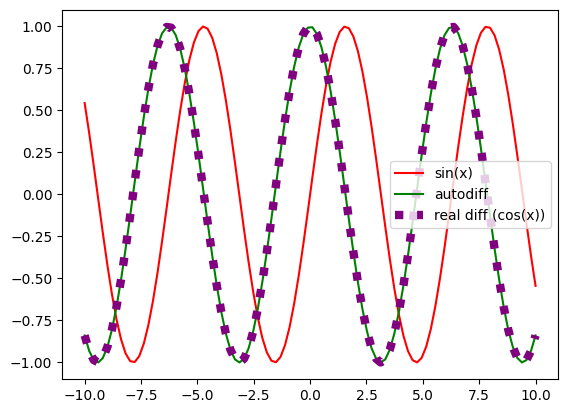

In [22]:
x = np.linspace(-10, 10, 100)
sin_x = [sin_approx(D(i, D(1, 2))) for i in x]
plt.plot(x, [a.v for a in sin_x], label="sin(x)", color="red")
plt.plot(x, [a.d.v for a in sin_x], label="autodiff", color="green")
plt.plot(x, np.cos(x), label="real diff (cos(x))", color="purple", linestyle="dotted", linewidth=6)
plt.legend()